# Table of Contents:

-import all packages that we may need<br>
-display first five rows<br>
-select data from 1st Jan 2013 to 28th Feb 2014<br>
-describe the data to see mean, std, percentiles etc..<br>

-plotting all columns with respect to time for original data<br>
-Correlations matrix of original data<br>
-histograom of original data<br>

# removing outliers
-removing outliers<br>
-another sanity check to make sure that there are no nan<br>
-plotting all columns with respect to time after removing outliers<br>
-corelation of all the features (on x-axis) with the target variable Energy (on y-axis) - after removing outliers<br>
-Correlations matrix of data with removed outliers<br>
-histogram for data after removing outliers<br>

# resampling
-resampling of data over each day<br>
-plotting all columns with respect to time for re-sampled data<br>
-Correlations matrix for re-sampled data<br>

# scaling
-data scaling from 0 to 1<br>

# static characteristics


In [77]:
#Title: Energy forecasting using LSTM Networks
#Author: Arslan Ahmed (arslan.m.ahmed@gmail.com)
#Date: 25th July, 2018

#import all packages that we may need

import sys 
 # linear algebra
import numpy as np
from scipy.stats import randint
import pandas as pd # data processing
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn import preprocessing # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import ExtraTreesClassifier
from scipy import signal


## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from pandas import concat
import matplotlib.dates as md
import statsmodels.api as sm

In [78]:
#function to convert time series data to apply supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [79]:
#read data

df_original = pd.read_csv('MIT_weather_energy__Apt2and91_3years.csv', parse_dates=['time'], infer_datetime_format=True, na_values=['nan','?'], index_col='time')

In [132]:
df=df_original;

In [133]:
#select data from 1st Jan 2013 to 28th Feb 2014
df_date=df['2014-10-08':'2016-12-15']

In [134]:
#already resampled and inerpolated and put into excel
df['Apt2'] *= 1000
df['Apt91'] *= 1000

In [135]:
print(df.shape)

(76930, 13)


In [136]:
#df['Day of week'] = df.index.weekday.astype(int)
#df["Weekend"] = (df["Day of week"] > 5).astype(int)

In [137]:
#display first five rows
df.head()

,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Apt2,Apt91
time,,,,,,,,,,,,,
2014-07-10 10:45:00,67.650,0.6475,10.0,67.650,1017.8125,11.840,0.2675,187.25,0.000675,55.4475,0.0075,459.946667,2406.093333
2014-07-10 11:00:00,67.930,0.6400,10.0,67.930,1017.7300,11.960,0.3100,187.00,0.000900,55.4800,0.0100,123.456667,568.082222
2014-07-10 11:15:00,68.355,0.6275,10.0,68.355,1017.6375,12.435,0.2850,188.25,0.000675,55.2575,0.0075,451.978889,237.175556
2014-07-10 11:30:00,68.780,0.6150,10.0,68.780,1017.5450,12.910,0.2600,189.50,0.000450,55.0350,0.0050,16.505556,920.024444
2014-07-10 11:45:00,69.205,0.6025,10.0,69.205,1017.4525,13.385,0.2350,190.75,0.000225,54.8125,0.0025,446.107778,136.916667


In [138]:
no_of_features=len(df.columns)

In [139]:
#describe the data to see mean, std, percentiles etc..
df.describe()

,temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Apt2,Apt91
count,76930.000000,76930.000000,76930.000000,76930.000000,76930.000000,76930.000000,76926.000000,76930.000000,76930.000000,76930.000000,76930.000000,76926.000000,76926.000000
mean,48.991110,0.676806,9.102416,46.329022,1017.197322,6.529836,0.218827,207.447559,0.003208,37.602350,0.060763,1365.377338,687.320226
std,19.511738,0.191140,1.757791,22.538202,7.862853,3.842208,0.272754,100.020058,0.015765,19.495250,0.171384,1530.051691,1073.252597
min,-13.050000,0.130000,0.400000,-32.990000,986.100000,0.020000,0.000000,0.000000,0.000000,-27.690000,0.000000,0.000000,0.000000
25%,34.685000,0.527500,9.180000,29.743125,1012.002500,3.630000,0.035000,162.250000,0.000000,24.415625,0.000000,301.841666,34.615000
50%,48.770000,0.700000,9.975000,46.788750,1017.256250,5.820000,0.120000,217.750000,0.000000,38.015000,0.000000,709.940555,162.877778
75%,64.700000,0.850000,10.000000,64.700000,1022.285000,8.626875,0.275000,290.250000,0.000000,54.334375,0.000000,2034.229722,670.562500
max,93.780000,0.980000,10.000000,98.450000,1044.540000,24.940000,1.000000,359.000000,0.426900,75.290000,0.900000,15499.726670,9665.283333


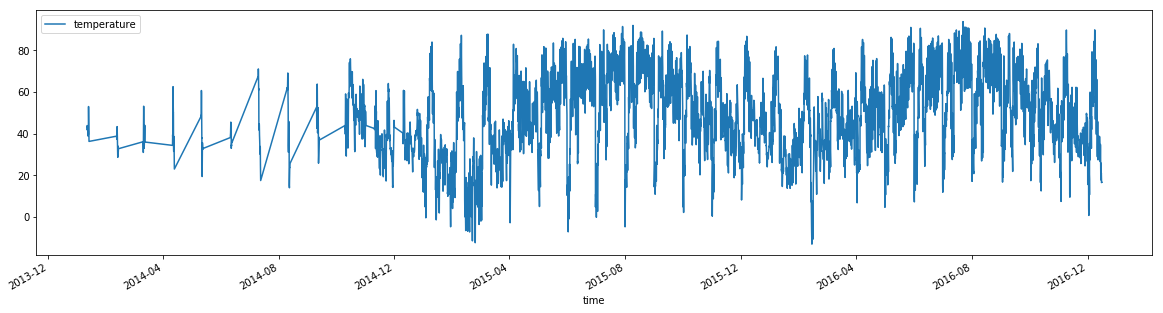

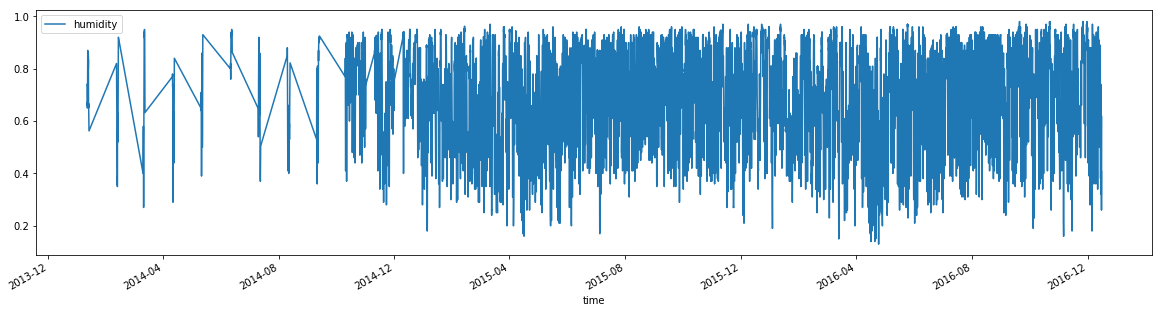

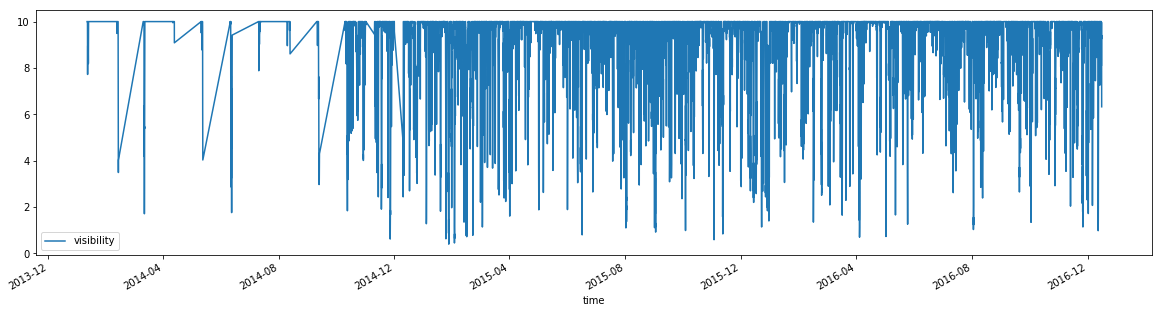

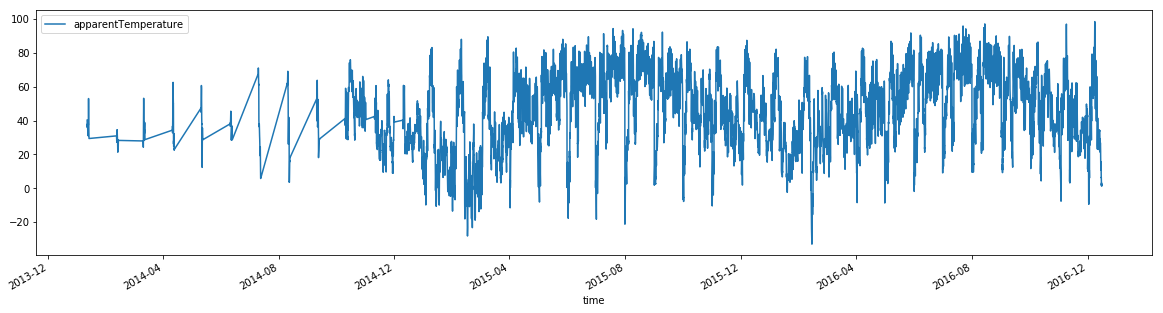

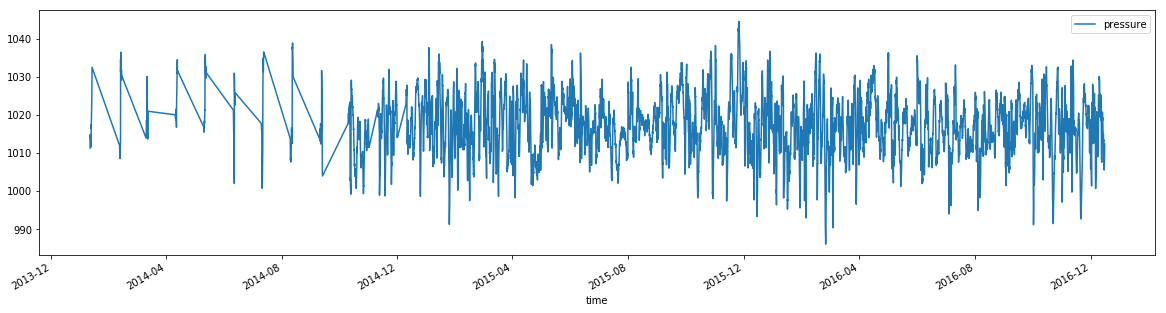

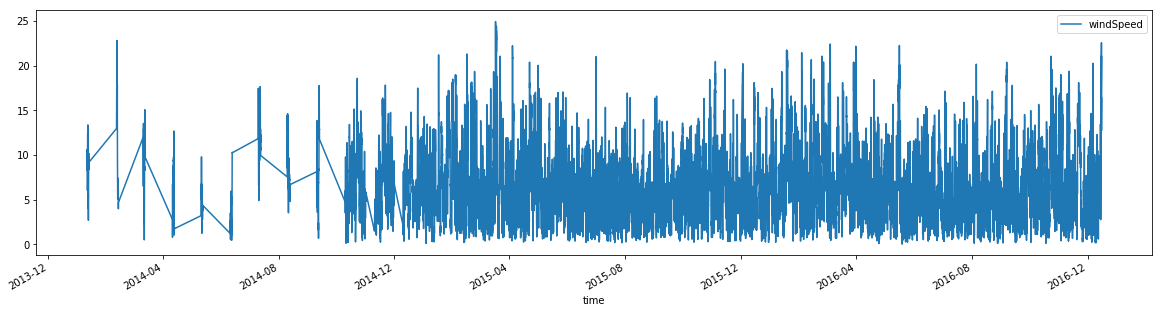

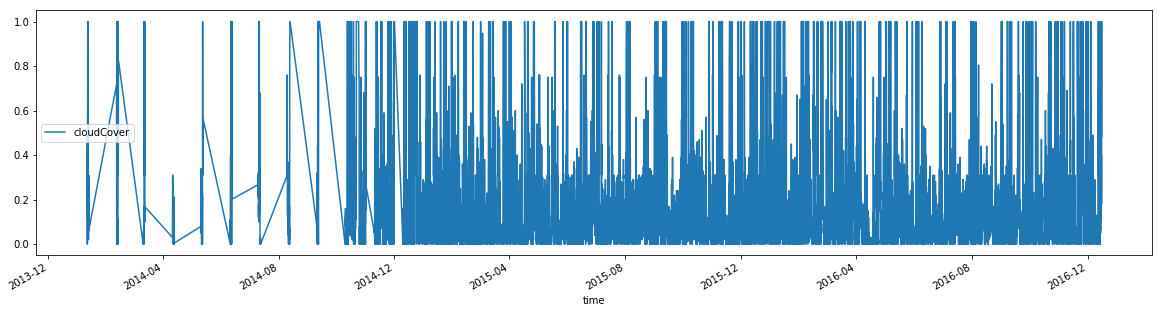

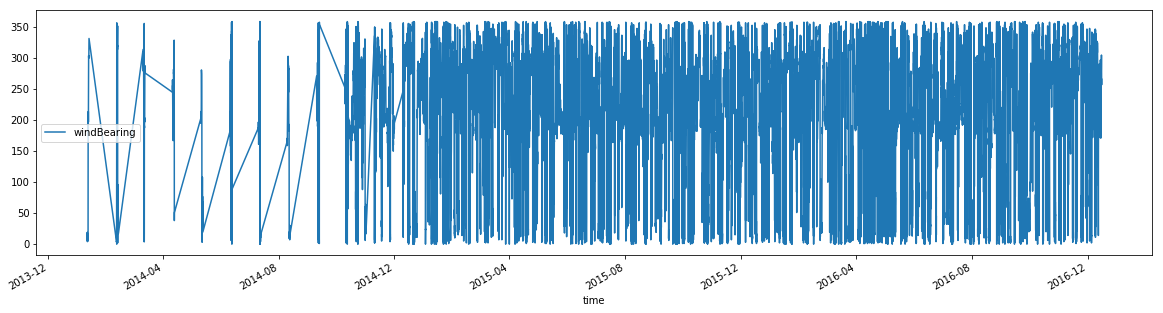

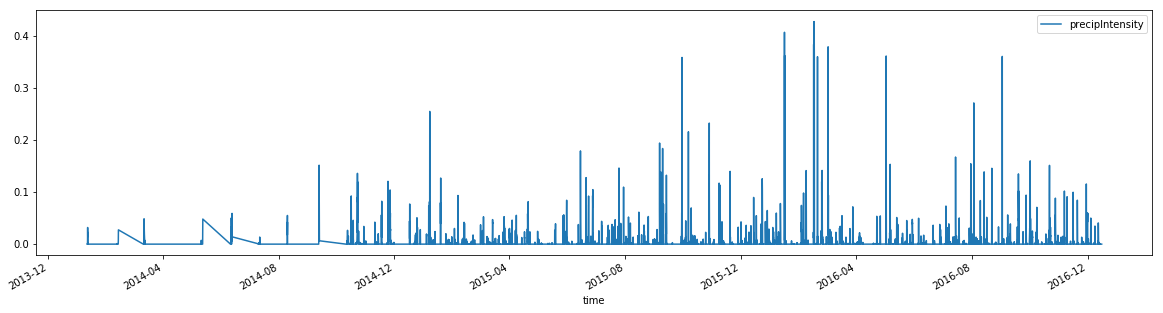

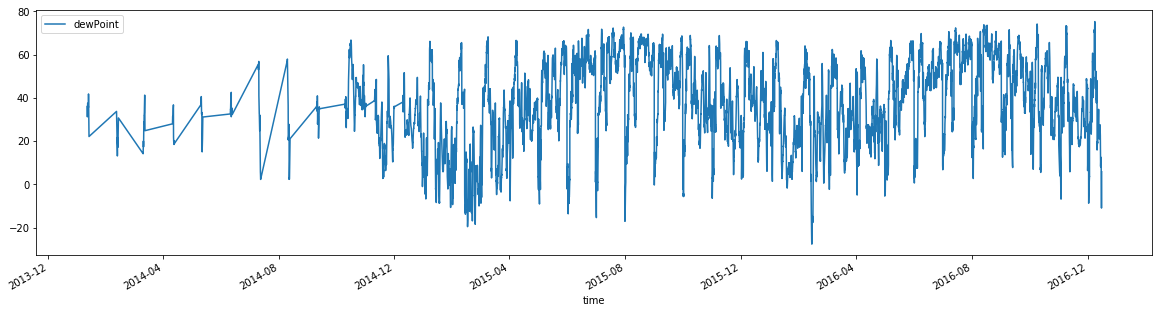

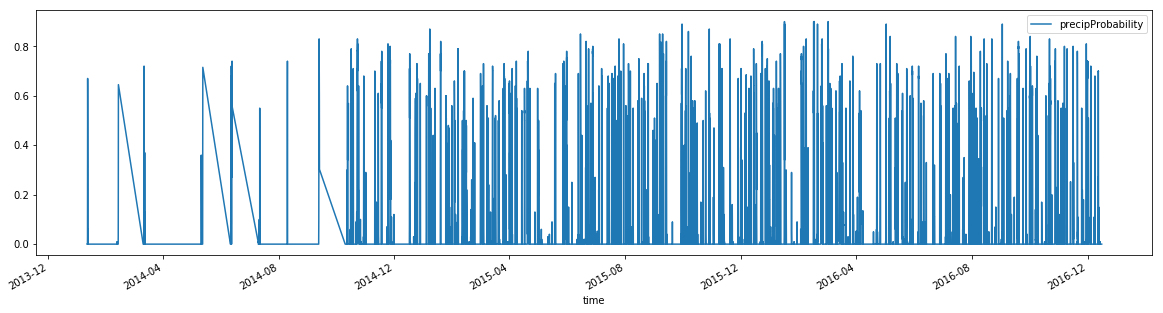

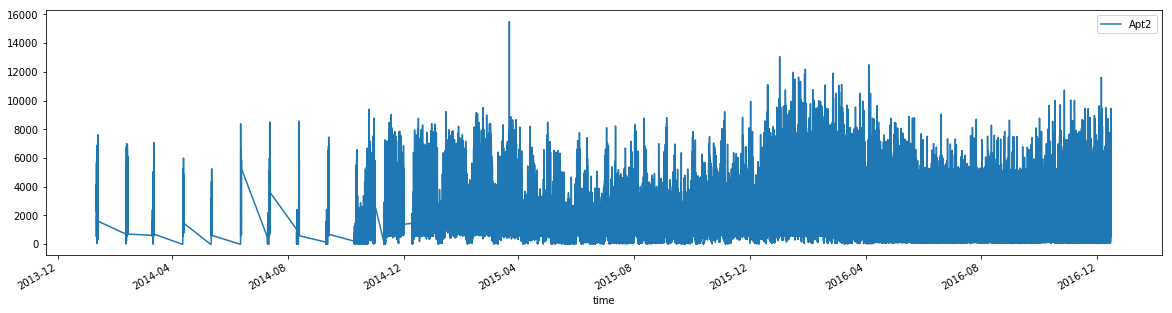

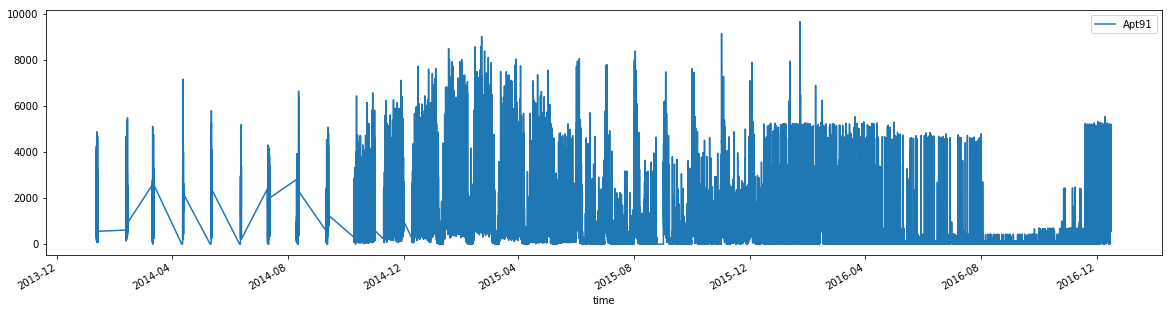

In [140]:
#plotting all columns with respect to time for original data
for j in range(0,no_of_features):        
        plt.figure(figsize=(20,5))
        df.iloc[:,j].plot(legend=True)

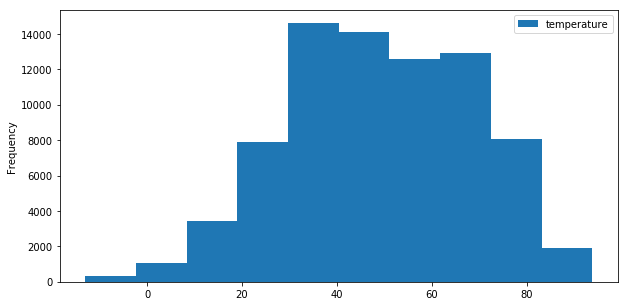

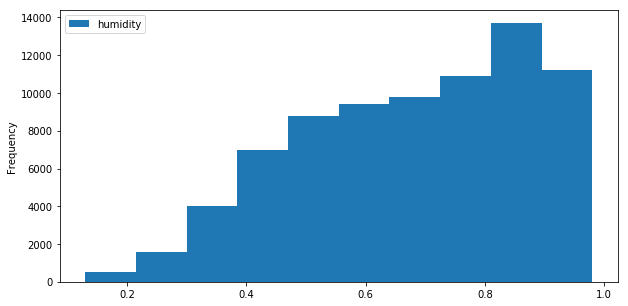

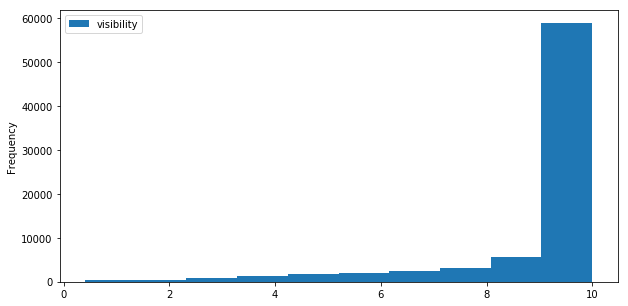

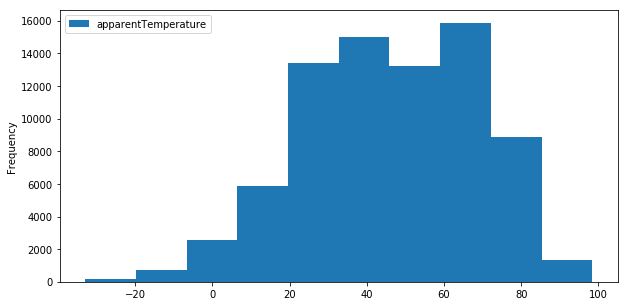

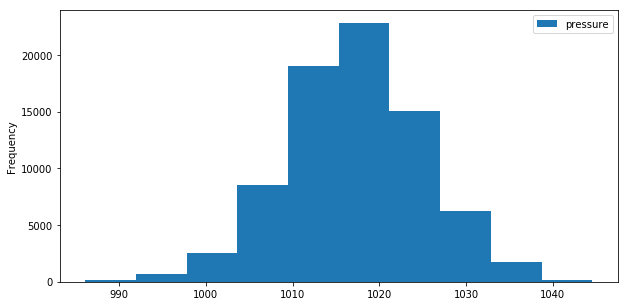

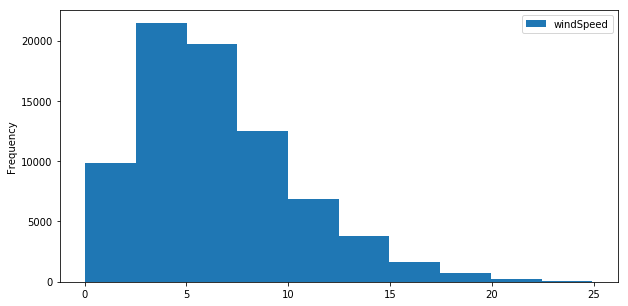

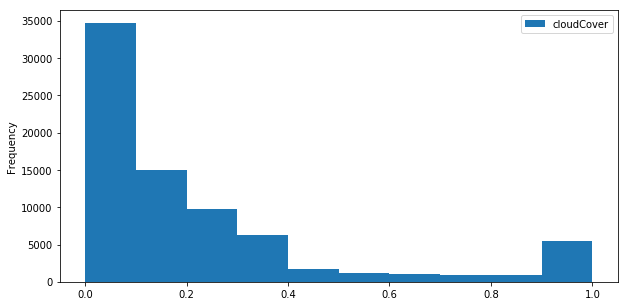

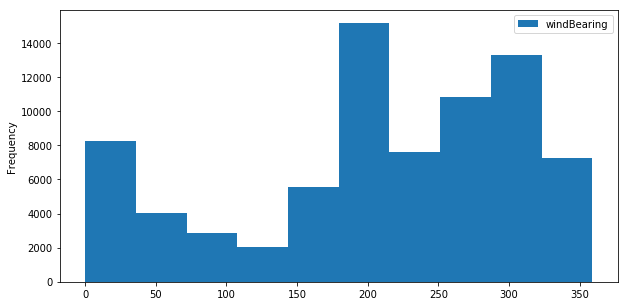

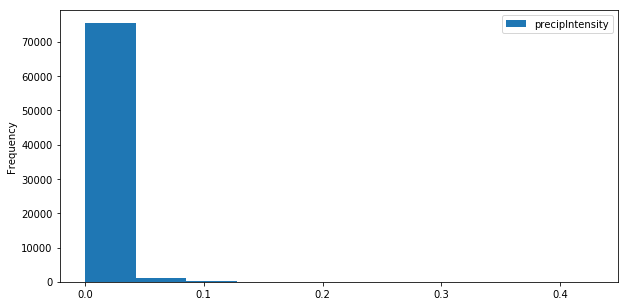

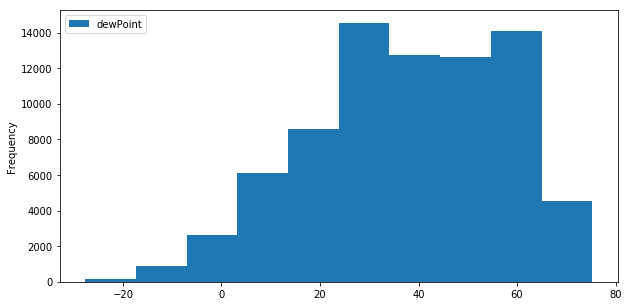

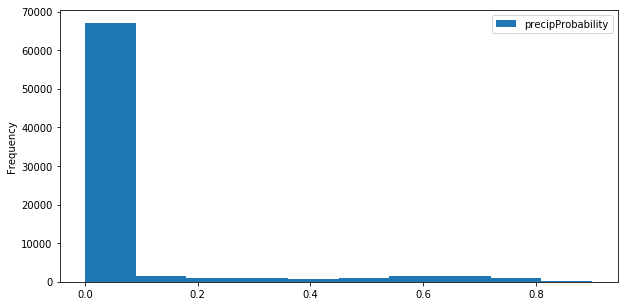

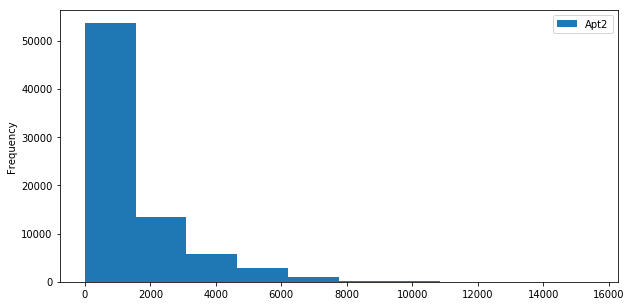

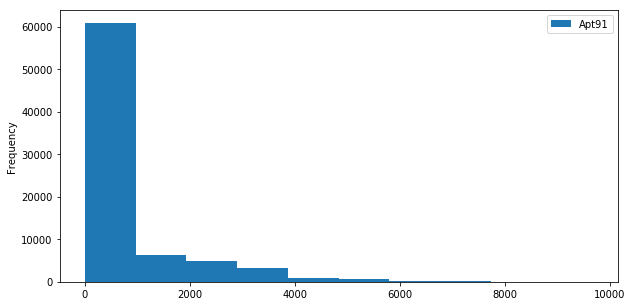

In [141]:
#histograom of original data

for j in range(0,no_of_features):        
        plt.figure(figsize=(10,5))
        df[df.columns[j]].plot.hist(legend=True)    

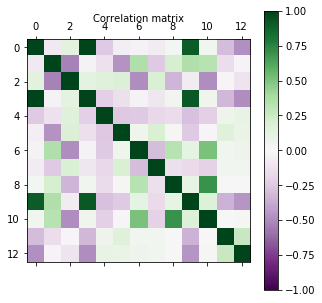

In [142]:
# Correlations matrix of original data
plt.figure(figsize=(5,5))
plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
plt.title('Correlation matrix', size=10)
plt.colorbar()
plt.show()

In [143]:
#removing outliers
#df[df.Apt2 > df.Apt2.quantile(.95)]=np.nan #data above 90 percentile will be filled with NaN
#df[df.Apt91 > df.Apt91.quantile(.95)]=np.nan
df=df.fillna(method='pad')

In [144]:
# another sanity check to make sure that there are no nan
df.isnull().sum()

temperature            0
humidity               0
visibility             0
apparentTemperature    0
pressure               0
windSpeed              0
cloudCover             0
windBearing            0
precipIntensity        0
dewPoint               0
precipProbability      0
Apt2                   0
Apt91                  0
dtype: int64

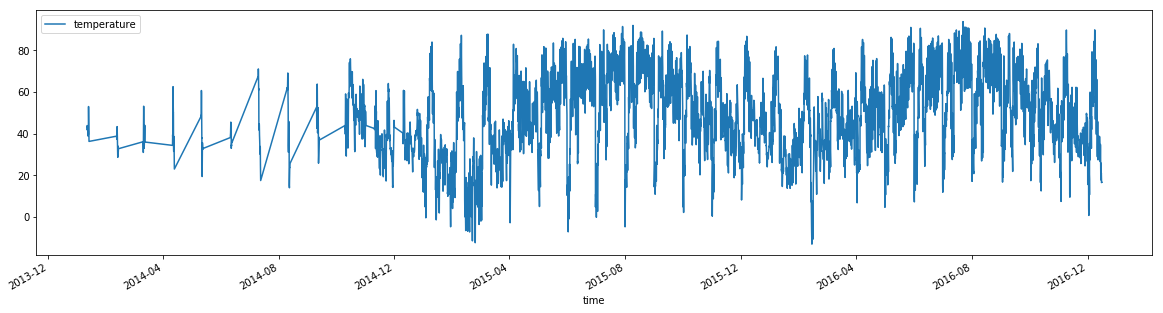

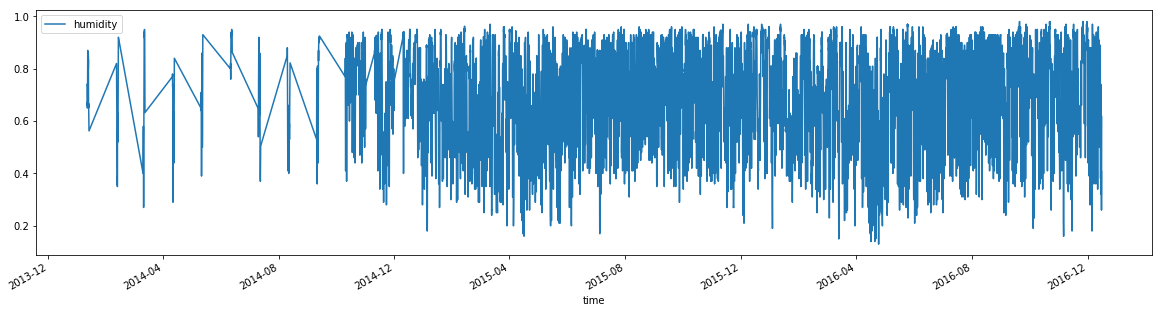

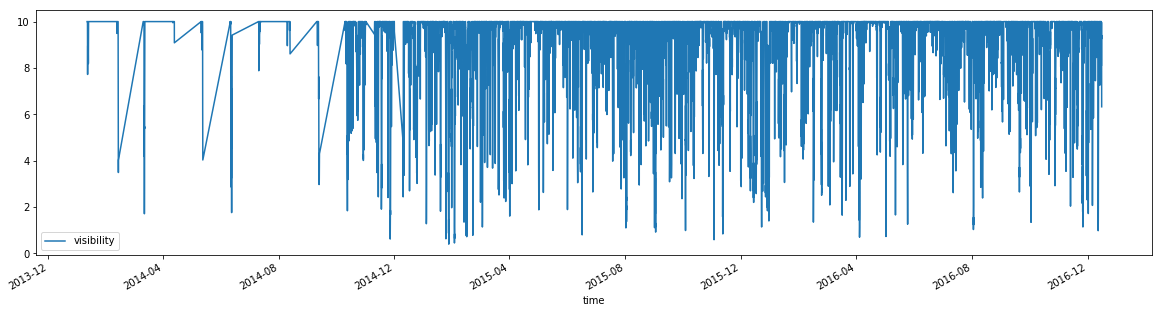

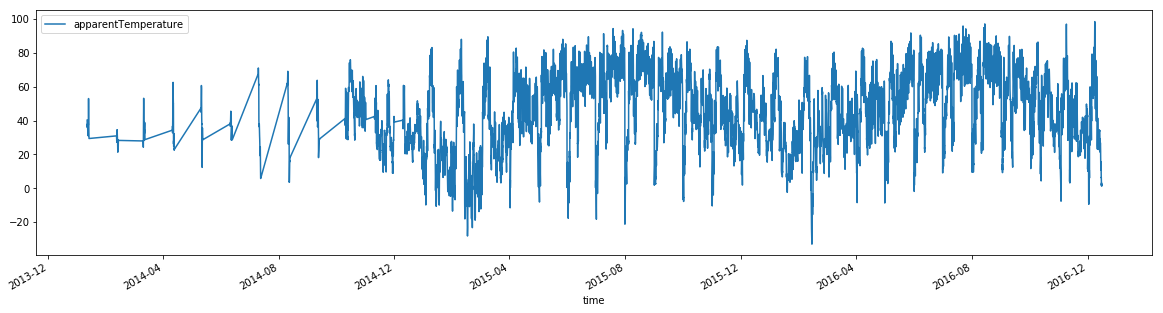

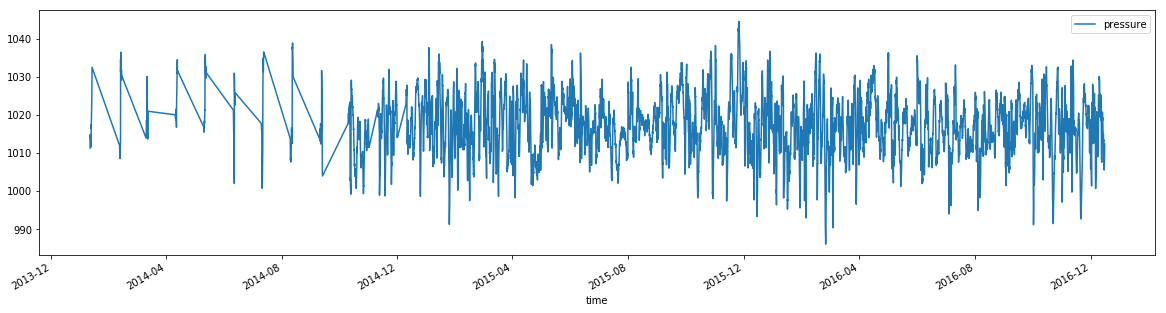

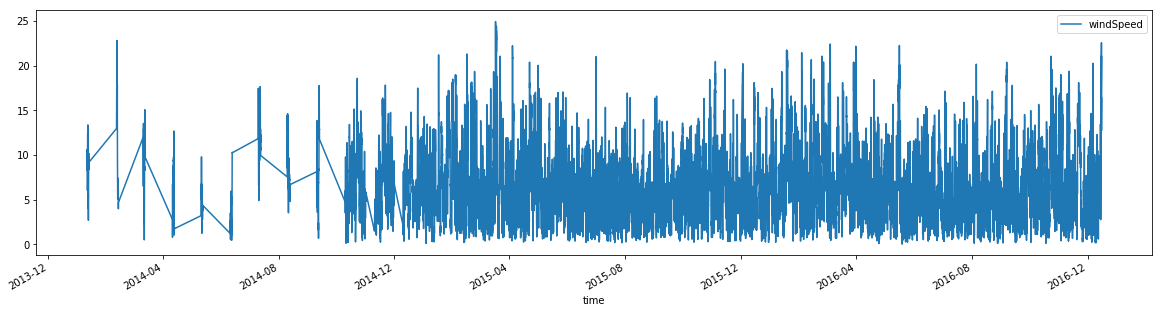

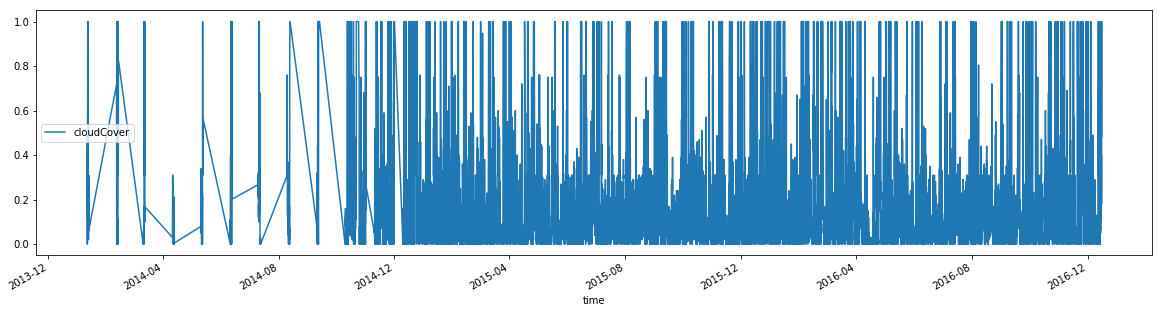

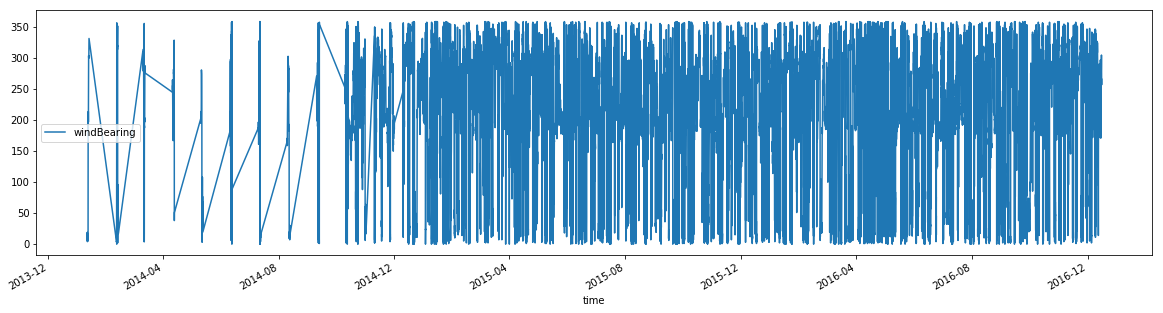

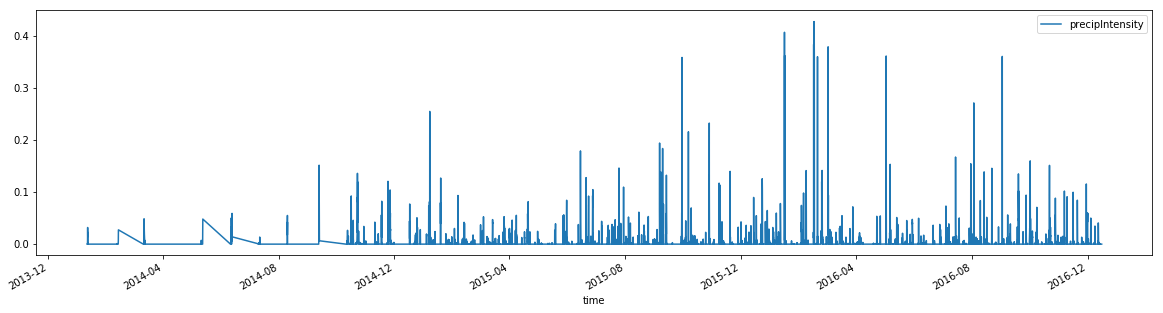

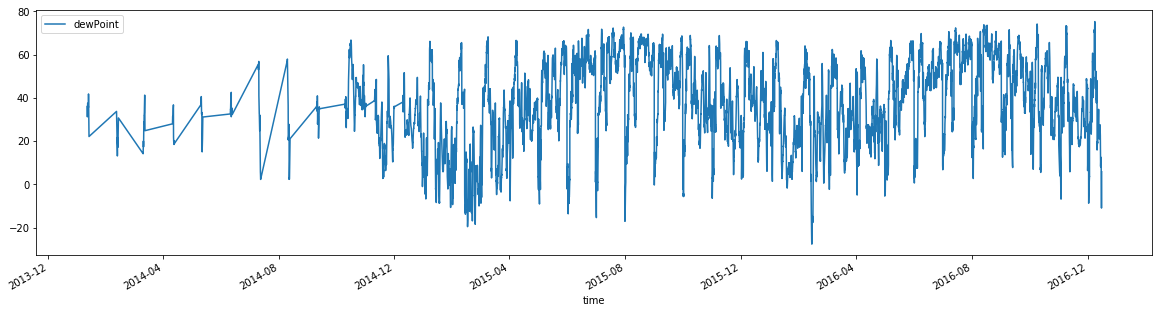

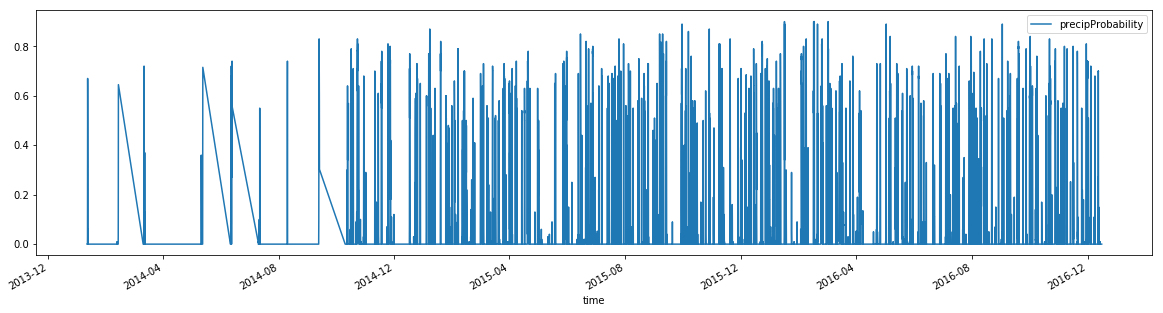

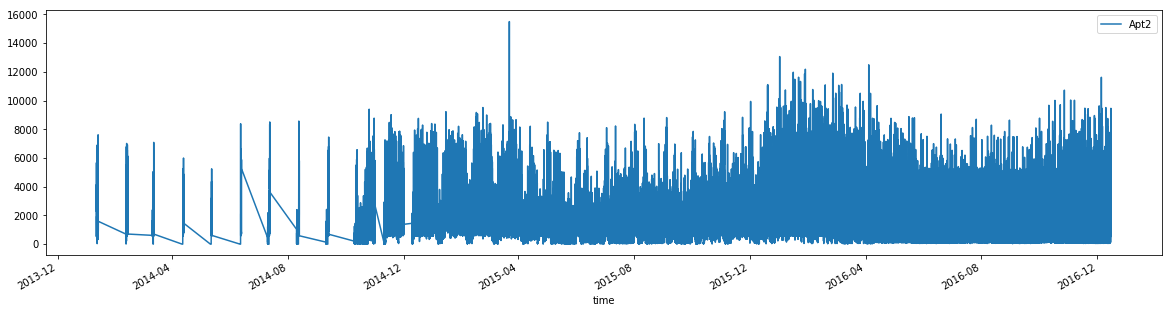

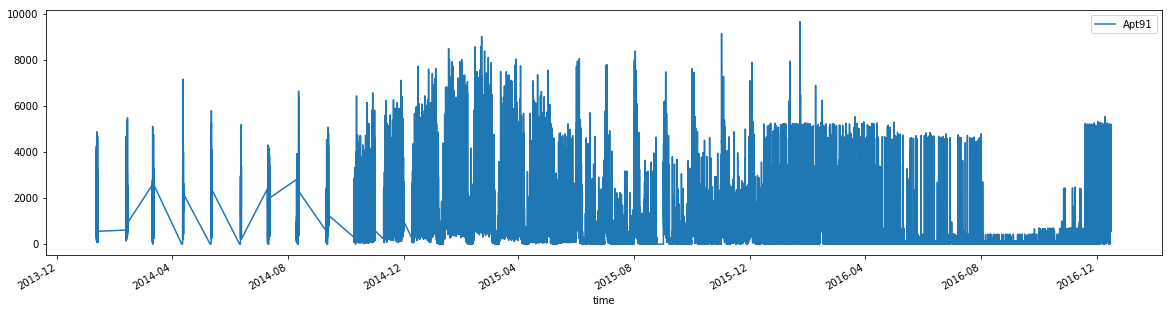

In [145]:
#plotting all columns with respect to time after removing outliers and missing values
for j in range(0,no_of_features):        
        plt.figure(figsize=(20,5))
        df.iloc[:,j].plot(legend=True)

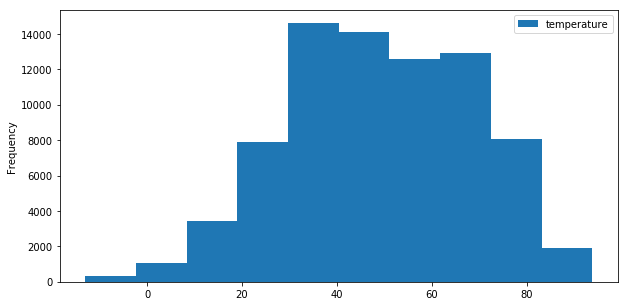

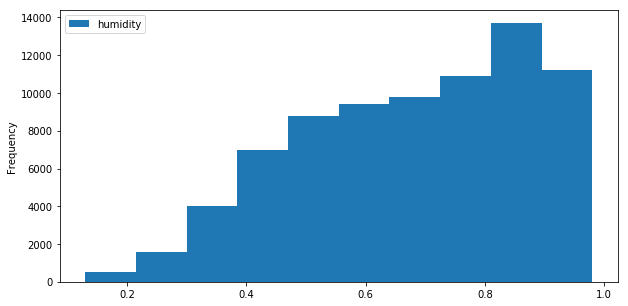

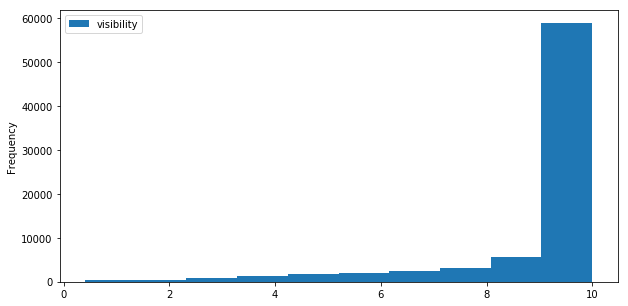

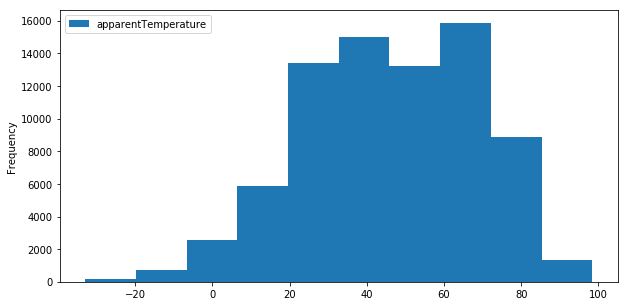

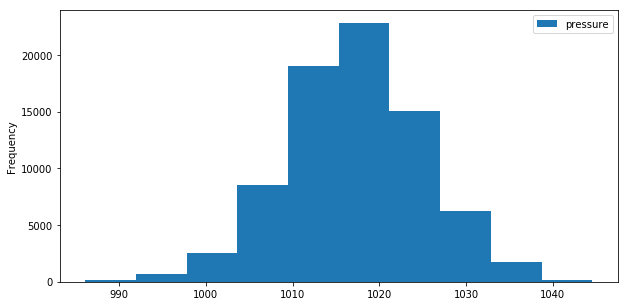

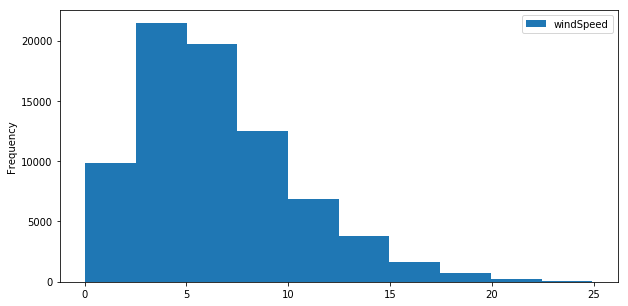

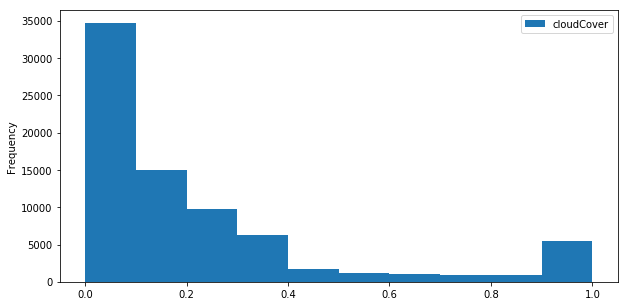

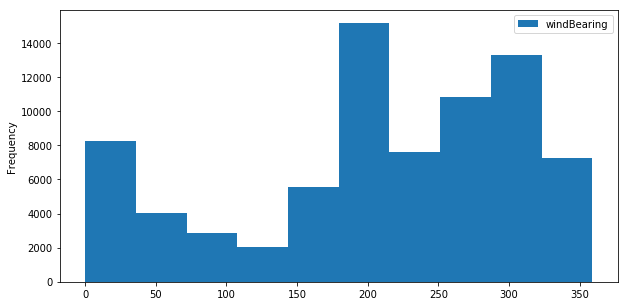

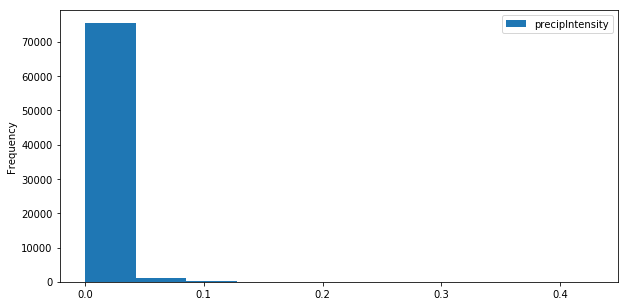

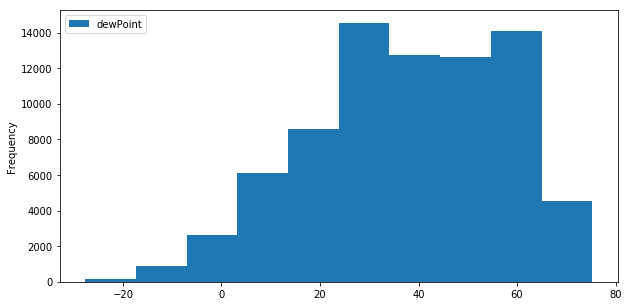

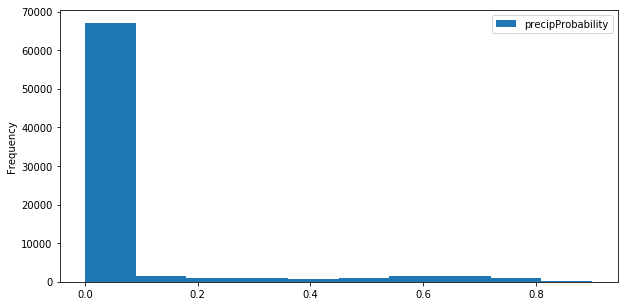

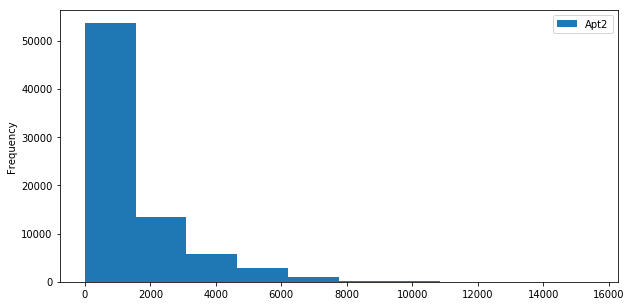

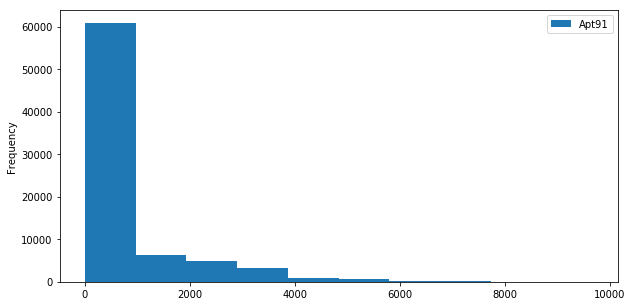

In [146]:
#histogram for data after removing outliers and missing values
for j in range(0,no_of_features):        
        plt.figure(figsize=(10,5))
        df[df.columns[j]].plot.hist(legend=True)    

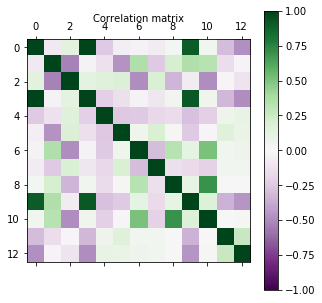

In [147]:
# Correlations matrix of data with removed outliers and missing values
plt.figure(figsize=(5,5))
plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
plt.title('Correlation matrix', size=10)
plt.colorbar()
plt.show()

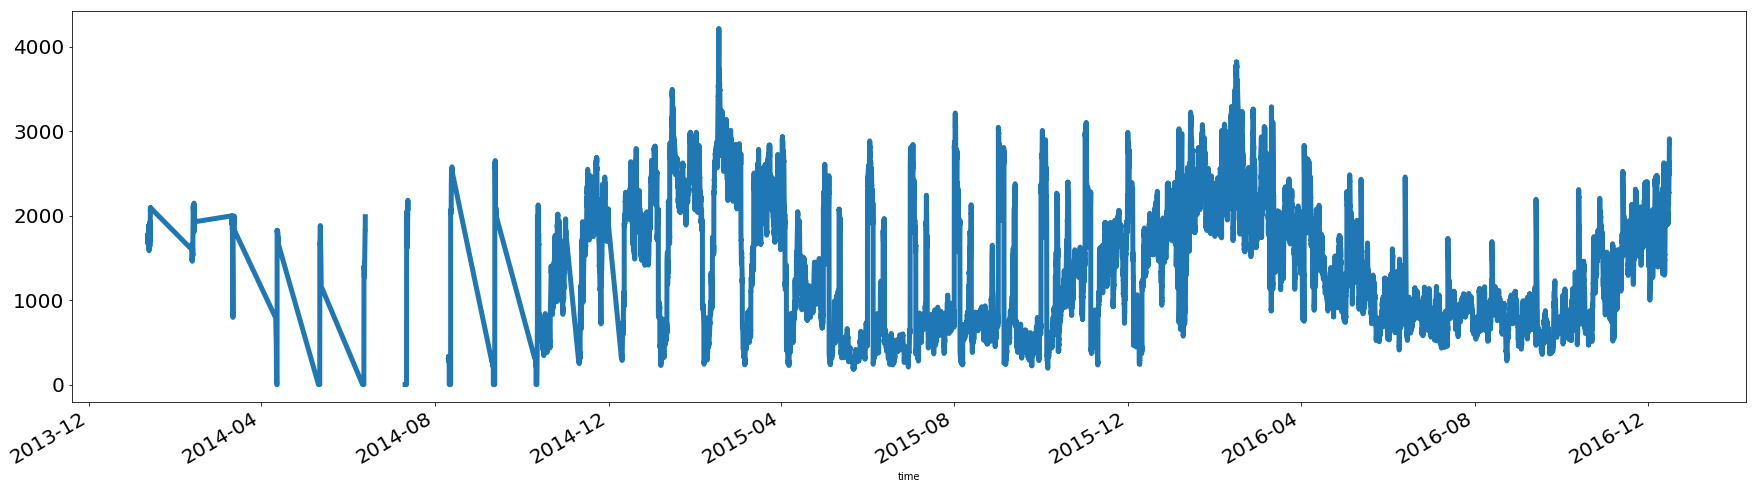

In [157]:
df['Apt2'].rolling(1*24*4).mean().plot(figsize=(30,8), linewidth=5, fontsize=20)

In [160]:
decompfreq = 1*24*4;

resultAdd = sm.tsa.seasonal_decompose(df['Apt2'],freq=decompfreq,model='add')

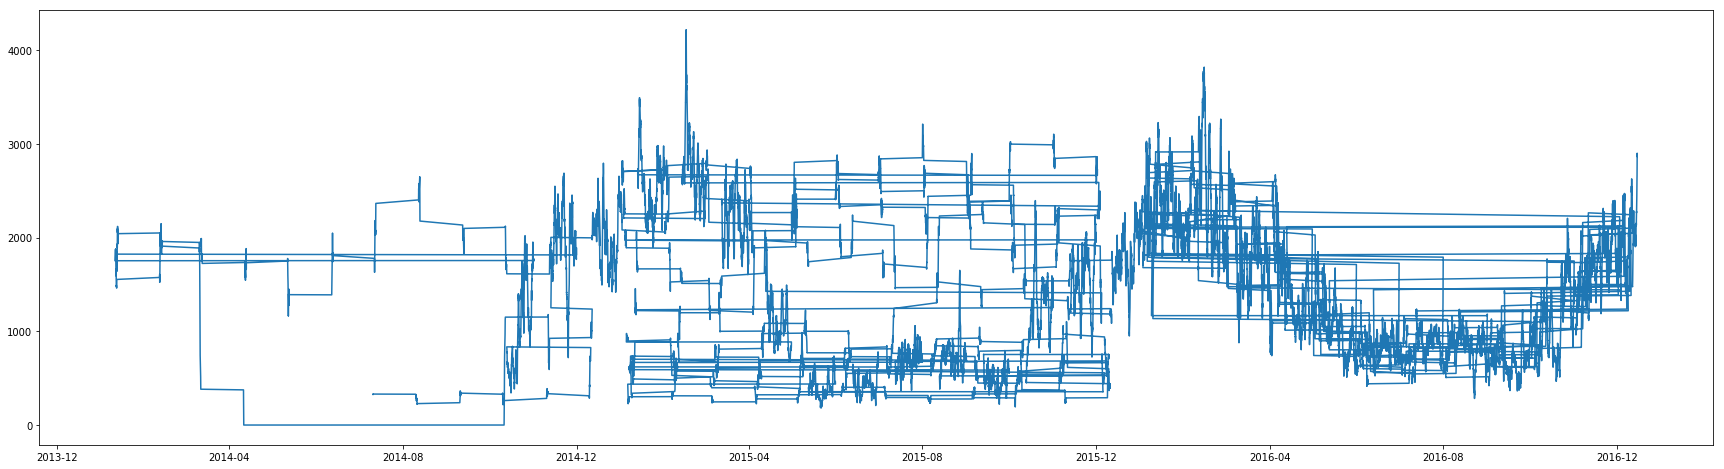

In [166]:
plt.figure(figsize=(30,8))
#result.plot()
plt.plot (resultAdd.trend)

In [67]:
model_tree = ExtraTreesClassifier()
alpha=df_date.iloc[:,0:11]
beta=df_date.iloc[:,11].astype(int)

In [68]:
#model_tree.fit(alpha, beta)
#print(model_tree.feature_importances_)

In [69]:
#drop features that are correlated with each other
df_date=df_date.drop(df.columns[[3,9]], axis=1) # apparant temp and dew point are highly correlated, so removed
#df=df.drop(df.columns[1:], axis=1)

In [70]:
#revised no. of features after dropping correlated features
no_of_features=len(df_date.columns)

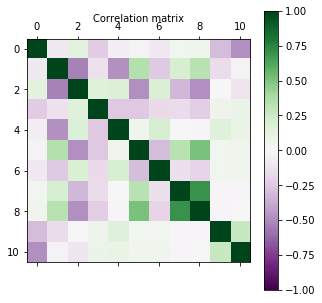

In [71]:
# Correlations matrix of data after dropping correlated features
plt.figure(figsize=(5,5))
plt.matshow(df_date.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
plt.title('Correlation matrix', size=10)
plt.colorbar()
plt.show()

C:\Users\Arslan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Arslan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Arslan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Arslan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Arslan\Anaconda3\lib\site-packages\matplotlib\axes\_axe

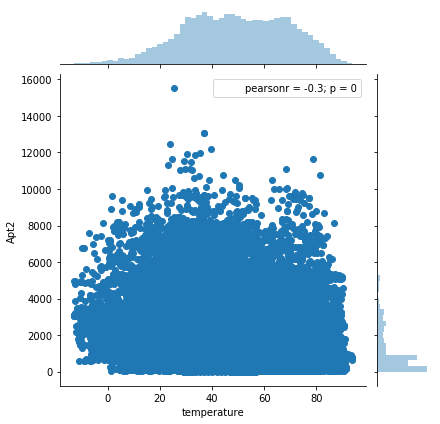

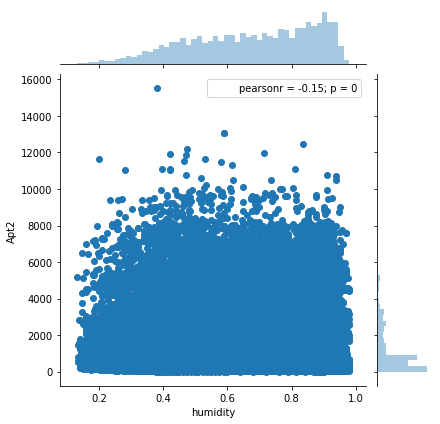

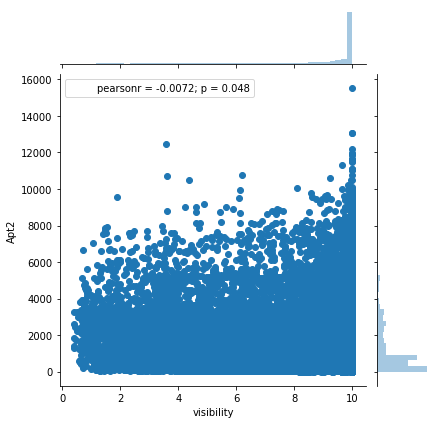

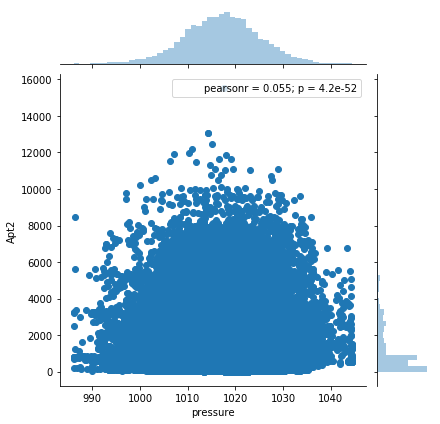

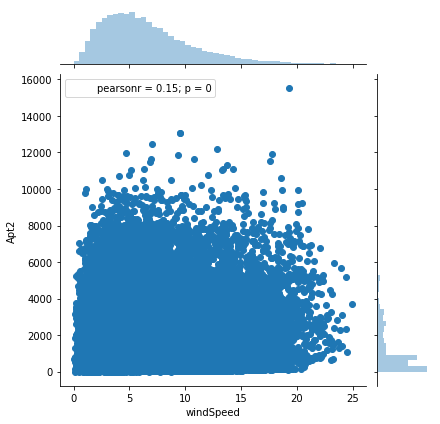

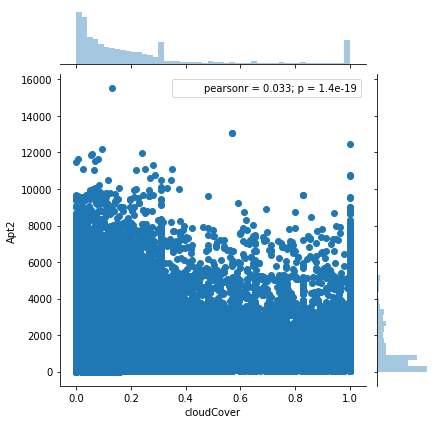

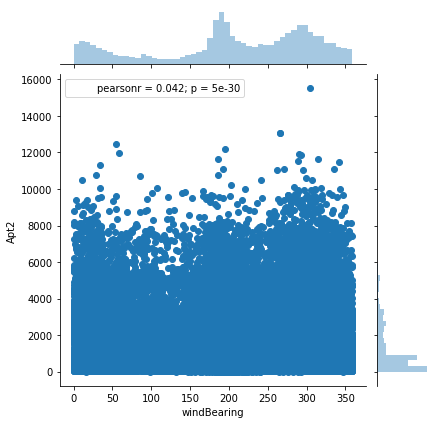

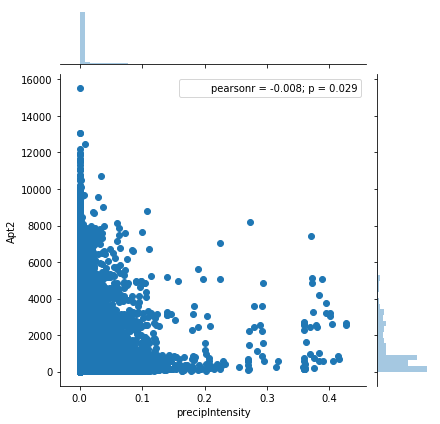

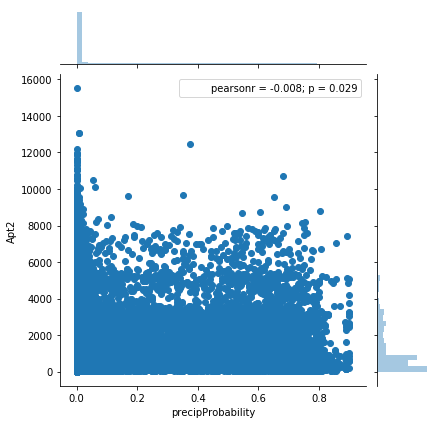

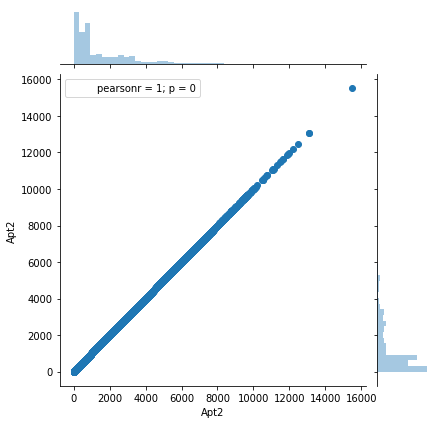

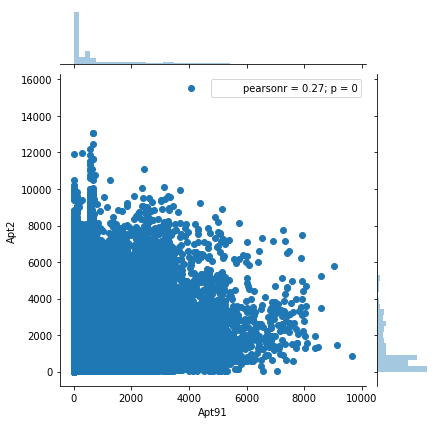

In [72]:
#corelation of all the features (on x-axis) with the target variable Energy (on y-axis) - after removing outliers and missing values
for j in range(0,no_of_features):
    sns.jointplot(x=df_date.columns[j],y=df_date.columns[9],data=df_date)

In [167]:
result = seasonal_decompose(df_date['Apt2'], model='additive')
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

ValueError: This function does not handle missing values

In [ ]:
#data scaling from 0 to 1 of original data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

In [ ]:
no_of_timesteps=1
reframed = series_to_supervised(scaled, no_of_timesteps, 1)
print(reframed.head())

In [ ]:
# drop columns we don't want to predict
col_array=np.arange(0,len(reframed.columns))
reframed=reframed.loc[:,(col_array<no_of_features*no_of_timesteps+1) | (col_array%(no_of_features)==0)]

In [ ]:
print(reframed.head())
print(reframed.shape)

In [ ]:

n_train_time = 2*24*84; # hours used for training.....
original_n_train_time=n_train_time;
pred_list=[]; #predicted values that will replace the original test_y values
testing_rows=2*24*4;#hours to predict
#testing_rows=reframed.shape[0]-original_n_train_time-1
test1 = reframed.values[n_train_time:n_train_time+testing_rows, :] #original testing data, this will later be modified with the predicted data generated by for loop
test_y1 = test1[:, -1] #see comment in above line
batch_size_fit=1

In [ ]:
train = reframed.values[:n_train_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], no_of_timesteps, no_of_features))
print(train_X.shape)

In [ ]:
#LSTM model
model = Sequential()
# model.add(LSTM(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.add(LSTM(20,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.add(LSTM(20,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(1))
# model.add(LSTM(10,return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dense(1))

# model.add(LSTM(20))



model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
# adam = keras.optimizers.Adamax(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=batch_size_fit, verbose=2, shuffle=True)

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:

for j in range(0,testing_rows):
    print('Loop # ',j)
    test = reframed.values[n_train_time:n_train_time+1, :]
    test_X = test[:, :-1]
    test_X = test_X.reshape((test_X.shape[0], no_of_timesteps, no_of_features))
    yhat = model.predict(test_X,batch_size=batch_size_fit)
    for k in range(0,len(reframed.columns),no_of_features):
        if((k+no_of_features)<(len(reframed.columns)-1)):
            reframed.values[n_train_time+1,k]=reframed.values[n_train_time,(k+no_of_features)];
    reframed.values[n_train_time+1,(len(reframed.columns)-1-no_of_features)]=yhat;
#     reframed.values[n_train_time+1,0]=yhat;
    n_train_time=n_train_time+1
    pred_list=np.append(pred_list,yhat)
    print(reframed[n_train_time-1:n_train_time])
    print(yhat)
n_train_time=original_n_train_time

In [ ]:
x_max=df.iloc[:,0].max()
x_min=df.iloc[:,0].min()
test_y1_un_scaled=test_y1*(x_max-x_min)+x_min
pred_list_un_scaled=pred_list*(x_max-x_min)+x_min

In [ ]:
plt.figure(figsize=(30,8))
# plt.rcParams.update({'font.size': 30})
plt.plot(test_y1_un_scaled,'go-', label='True data', linewidth=3)
plt.plot(np.roll(pred_list_un_scaled, -1),'bo-',label='Predicted Data', linewidth=3)
plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)


x=np.arange(0,len(test_y1_un_scaled),24)
y=df.index.strftime('%d-%b\n%I-%M-%p')[original_n_train_time::24]
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

plt.ylim(ymin=x_min,ymax=x_max)
plt.title('Short Term Electricity Forecasting', fontsize=30)
plt.legend(loc='upper left', fontsize=27,framealpha=0.5)
plt.savefig('5a.pdf', bbox_inches='tight')

rmse=np.sqrt(mean_squared_error(test_y1_un_scaled, np.roll(pred_list_un_scaled, -1)))
print('RMSE: ', rmse)
print ('NRMSE: ',((rmse)/(x_max-x_min)))

In [ ]:
rmse_propagate=[];
for e in range(2,len(pred_list_un_scaled)):
    rmse1=np.sqrt(mean_squared_error(test_y1_un_scaled[1:e], np.roll(pred_list_un_scaled[1:e], -1))) 
    rmse_propagate.append((rmse1-x_min)/(x_max-x_min))

    
plt.figure(figsize=(15,8))    
plt.plot(rmse_propagate, linewidth=3)

plt.ylabel('NRMSE', fontsize=20)
plt.xlabel('Time (half hours)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)    

x=np.arange(0,len(test_y1_un_scaled),24)
y=df.index.strftime('%d-%b\n%I-%M-%p')[original_n_train_time::24]
plt.xticks(x, y, rotation=80);

plt.ylim(ymin=0)
plt.title('Error vs Length of forecast', fontsize=30)
plt.savefig('Error.pdf', bbox_inches='tight')
plt.tick_params(axis='both', which='major', labelsize=30)


In [ ]:
#################DATA#####################

In [ ]:
pred_list_un_scaled=[143.85025099, 171.15367508, 189.18953931, 203.80116993,
       219.37358087, 228.37850136, 241.9074491 , 247.20903796,
       253.53932229, 259.56937635, 261.18187186, 268.11615688,
       268.72512621, 282.65069589, 294.61240935, 304.86396241,
       313.6279037 , 321.10099149, 327.45753199, 332.85183263,
       337.41981685, 341.28063893, 367.79841185, 395.14880514,
       408.91197783, 426.51029092, 448.97299886, 467.12463248,
       465.13835526, 459.54925275, 474.57977104, 467.23922181,
       461.57512385, 457.17806095, 472.28866756, 467.46604037,
       456.35106134, 459.60949755, 458.24007738, 472.60815132,
       483.46146917, 481.42128217, 485.43485898, 480.16359437,
       481.43944877, 472.1862514 , 435.40304428, 409.29856932,
       378.57173455, 360.90665531, 339.65256983, 325.01063049,
       311.80528116, 298.86882859, 291.91924948, 281.34762263,
       278.13149753, 269.20241097, 266.10784683, 262.47261667,
       258.8818714 , 270.83928388, 281.09731171, 312.71845567,
       340.2692095 , 364.01000774, 385.42240661, 396.36742699,
       405.19307262, 401.69114184, 402.38476443, 403.56267446,
       410.36465383, 418.36652946, 420.66803604, 422.42932689,
       418.17405665, 414.9824487 , 412.9616394 , 412.69035149,
       404.91926932, 399.01167679, 394.49934137, 391.04060674,
       388.3825379 , 386.3357985 , 384.75738478, 383.53876293,
       382.59711188, 381.86898828, 381.30569941, 380.86979413,
       380.53229904, 380.27094841, 356.70548117, 342.34386647,
       323.40793252, 307.37589103, 295.03073806, 279.37600291,
       270.66179463, 257.2673108 , 251.79428822, 238.89719662,
       226.68462878, 217.68346584, 211.1430079 , 210.27562255,
       203.30508196, 212.75478917, 221.17000934, 249.17665172,
       274.67779365, 297.87103188, 320.51230043, 336.08716464,
       348.77279389, 359.04124033, 365.26763344, 370.16044271,
       383.6644696 , 390.66109556, 392.96741551, 398.15098357,
       384.50615776, 381.27026677, 374.35757983, 382.80750287,
       376.32752264, 371.48402715, 380.83110082, 379.79374129,
       379.01468909, 378.4292587 , 377.98916113, 377.6582495 ,
       377.40932047, 377.22206473, 377.08117265, 376.97515422,
       376.8954075 , 376.83538008, 357.72448778, 335.12607378,
       324.85629201, 307.48777866, 298.17269063, 284.44634801,
       273.18440583, 263.93401885, 251.65468487, 248.08218384,
       239.33231002, 237.5437848 , 236.18344793, 232.1536454 ,
       228.8570438 , 226.16167909, 257.73712707, 271.99331337,
       292.45472947, 314.69917423, 333.06424212, 348.11730564,
       360.36675012, 361.56897545, 348.25357068, 342.02984822,
       337.47664571, 334.13799697, 356.88683665, 357.73889685,
       350.51678765, 345.2456162 , 341.38734055, 338.55757403,
       336.47922164, 334.95120859, 347.60466588, 352.41903269,
       365.61133933, 376.13194442, 384.46538383, 391.02849567,
       396.17265618, 400.18887258, 403.31464601, 405.74133134,
       388.15211707, 359.22181946, 335.36876094, 311.68566108]

In [ ]:
pred_list_un_scaled_SVR=[121.38080601, 123.28799005, 129.95591467, 138.37574005,
       142.41004862, 155.72081138, 163.50718946, 175.31686841,
       184.24715211, 195.31061633, 207.96753964, 225.05546643,
       233.79939091, 270.91918537, 307.19191926, 339.10605574,
       364.38655391, 382.29371073, 393.52872277, 399.8216732 ,
       403.05597303, 404.63101463, 410.28866286, 404.15919381,
       413.30284945, 416.77813536, 379.18868995, 352.64795921,
       366.33308851, 378.97137716, 347.658705  , 360.61270229,
       371.92022205, 381.71875271, 359.57777912, 377.97973404,
       396.03660065, 406.7122879 , 418.58961834, 378.83047725,
       356.21080034, 360.19249115, 349.68033034, 354.8379791 ,
       355.23449999, 361.1429976 , 343.03159257, 338.19274788,
       306.6402061 , 305.56494039, 292.54656366, 289.33259826,
       284.99357113, 278.7564503 , 280.67337428, 274.84404263,
       280.00472901, 272.48763443, 273.66229604, 272.43394194,
       269.73116047, 295.50470353, 315.52653382, 324.27055388,
       331.94595997, 338.74231121, 338.68418679, 357.82506646,
       375.28734271, 379.78687322, 390.80933776, 399.49167248,
       406.18926778, 402.8321476 , 406.83136007, 409.70733603,
       401.21671154, 396.20509793, 401.20829969, 402.73711415,
       381.05023742, 369.67445706, 363.3361503 , 359.73485705,
       357.67252193, 356.48722203, 355.80475312, 355.4114262 ,
       355.18462115, 355.0537995 , 354.97832869, 354.93478555,
       354.90966181, 354.89516533, 313.21195601, 303.03779314,
       278.4937598 , 265.54038557, 258.54447566, 245.1092916 ,
       233.85895052, 220.05961043, 210.92094135, 174.63673123,
       169.91122264, 137.73497888, 151.05560795, 151.82204612,
       149.2571489 , 177.31184623, 192.99611237, 233.70375829,
       262.20125658, 281.10739653, 312.20331311, 348.32192502,
       380.68097273, 410.27631984, 427.19896855, 439.79819283,
       454.69417062, 468.05109454, 464.53649805, 462.80015932,
       379.42594274, 373.31339692, 340.93629603, 355.61372395,
       331.80078704, 320.63329564, 330.63472535, 336.24285621,
       339.75255716, 341.93772829, 343.29353597, 344.13285966,
       344.65169916, 344.97213442, 345.16992226, 345.29196293,
       345.36724886, 345.41368583, 293.66933733, 262.281782  ,
       257.3617487 , 241.9432425 , 243.66313127, 238.6131944 ,
       235.66388053, 233.90925671, 233.73852709, 238.49291592,
       233.76200103, 234.49396803, 233.67646401, 230.546962  ,
       228.44114502, 227.00838223, 258.82230194, 300.32934638,
       333.04777525, 361.42283344, 391.08468463, 421.43264495,
       450.34713556, 412.31304268, 297.86956886, 260.18563813,
       244.3277007 , 237.38819845, 240.05460872, 256.68070366,
       249.56664993, 246.19877794, 244.58888011, 243.81581136,
       243.44378415, 243.26456738, 267.3279816 , 293.93802821,
       311.9564719 , 331.81637488, 354.03457468, 379.07589687,
       407.06062589, 437.03195402, 465.80040982, 487.94849559,
       387.54197042, 304.8736943 , 276.30126548, 259.86135128];

In [ ]:
rmse_propagate=[0.0866673226091088,
 0.13613987296400182,
 0.14720205841647122,
 0.16280277147592687,
 0.18525063913186363,
 0.20721806554956643,
 0.21689764046868398,
 0.22186679328244951,
 0.23216341559460923,
 0.23907731725936376,
 0.2388306396023267,
 0.2406135964825353,
 0.22839648948197236,
 0.21743610091023305,
 0.2076244703992194,
 0.19884714751748012,
 0.19099115710939388,
 0.1839495897331033,
 0.1776240749692018,
 0.17192588336691655,
 0.16822460883375215,
 0.15736134215167072,
 0.17525892946703706,
 0.18974268499860678,
 0.21011029607098944,
 0.2312931962957883,
 0.25167624524742527,
 0.2634247710911403,
 0.27797430683395524,
 0.29325824481568624,
 0.3027460348608703,
 0.3109080147938333,
 0.3197994068272921,
 0.3188441883626217,
 0.32181019917966913,
 0.31942051803935484,
 0.31503515287366884,
 0.3091775407072325,
 0.30345582440395324,
 0.3087283723797945,
 0.2991146514025732,
 0.29033271626696316,
 0.2873677120699362,
 0.2838629225963923,
 0.28239997714870524,
 0.28321533787163833,
 0.2808595498176245,
 0.2778550606240834,
 0.2745632931182459,
 0.27219738435695273,
 0.2699525803920274,
 0.26741260270349804,
 0.2642882466339438,
 0.26079517642583067,
 0.25727656554521416,
 0.2544588976044747,
 0.2519195616292613,
 0.24982336342736433,
 0.2469605015807465,
 0.24545582942096134,
 0.24310540943350234,
 0.2443523811263226,
 0.24289144425533649,
 0.2409976760519846,
 0.23583754475600027,
 0.23501054342946787,
 0.23272788674845693,
 0.23143211873102246,
 0.22832179115739867,
 0.22839277218517604,
 0.22606894760138402,
 0.2210493096214544,
 0.2188798664657942,
 0.21763799954867716,
 0.2228671905448684,
 0.2213281276992661,
 0.2150269766503561,
 0.21777429454070793,
 0.21461678771749482,
 0.21295657826485567,
 0.2113705855130032,
 0.20985072442872718,
 0.20838916403400012,
 0.20697890108222383,
 0.20561392473000736,
 0.20428919257510328,
 0.2030005257951621,
 0.2017444810115684,
 0.20051822416094855,
 0.1993194169151331,
 0.19814611991257794,
 0.19699671395317964,
 0.1905528176743588,
 0.19371238018914344,
 0.19601935367850826,
 0.19870614812442083,
 0.20077491131621933,
 0.2021228016092838,
 0.20298199097306985,
 0.20363693357466434,
 0.20464916477373243,
 0.20594511788070136,
 0.20650614199161185,
 0.20653605038916864,
 0.20622213100746928,
 0.2058408398581506,
 0.20542580075635203,
 0.20476766474095062,
 0.20418670585947163,
 0.20355030251208872,
 0.20308691830312653,
 0.20301714028280424,
 0.20558618454858266,
 0.2027713464706074,
 0.20183249010028353,
 0.20101469492437105,
 0.20630699870621724,
 0.20629477247009706,
 0.1999186926993023,
 0.2027323493578046,
 0.20574914447969522,
 0.20851792876916575,
 0.2126952440085288,
 0.216513813556165,
 0.20958316194513202,
 0.21183351644836468,
 0.21614833576730333,
 0.21562836089727144,
 0.2122096490228349,
 0.21010432679408633,
 0.20924434986641474,
 0.2083897014219253,
 0.20754155935314766,
 0.20670073954135934,
 0.20586779707834835,
 0.20504309730758316,
 0.20422686807612572,
 0.20341923654479918,
 0.2026202564716652,
 0.2018299283481384,
 0.20035014549210975,
 0.20239492958152222,
 0.20363140402895963,
 0.20540118801008397,
 0.20649120481089833,
 0.2074492349298681,
 0.20811568719134732,
 0.20858761447648436,
 0.2090782289294848,
 0.20773026980354214,
 0.20711043717771893,
 0.20713271946453096,
 0.2074333375261134,
 0.20746246563968354,
 0.20723236391093805,
 0.20697039978408519,
 0.20696974060633325,
 0.20717319637861914,
 0.20692685607425973,
 0.20696170957150672,
 0.20683407947334448,
 0.2069227679491746,
 0.20720543975983638,
 0.2124271929308868,
 0.20792756909489232,
 0.2101964917991134,
 0.20968505011346675,
 0.20921249406694173,
 0.20607371725008036,
 0.2068752617694165,
 0.2073467557937588,
 0.20655376031781095,
 0.20577863713949263,
 0.20501961071885846,
 0.20427474339716267,
 0.2035422655807847,
 0.2012556065505554,
 0.2019801038117789,
 0.20334716286636131,
 0.20484658944272388,
 0.20651536404213675,
 0.2083134191640517,
 0.21020648820526502,
 0.21216619148156884,
 0.21416960456504514,
 0.2161985793327668,
 0.21867037870903824,
 0.2177836205559316,
 0.2174770107705525,
 0.21915116871913792]

In [ ]:
rmse_propagate_SVR=[0.06773126689166467,
 0.10877642413766866,
 0.11097431573228521,
 0.1164723731585039,
 0.1356419685844247,
 0.15307668647762082,
 0.16232541269417813,
 0.1665540303267918,
 0.17757755559729554,
 0.18997431235642825,
 0.19694650377145745,
 0.21661390645199158,
 0.20854375118393778,
 0.2010397810060953,
 0.1953941906052313,
 0.19201441689926144,
 0.19056358878702126,
 0.1903780220676527,
 0.19085656069186777,
 0.19161433182873286,
 0.19490077615472345,
 0.17894897518807049,
 0.20660804019821488,
 0.22503577934215085,
 0.24818782829151692,
 0.26247736619041,
 0.2723515136868156,
 0.2760232748210344,
 0.285361406317935,
 0.2918439722402029,
 0.2954725066247243,
 0.2997401311553458,
 0.3089048371105268,
 0.30514645484318625,
 0.3088556743119654,
 0.30802683779300827,
 0.30478784672268294,
 0.2993539285843159,
 0.29344173747594293,
 0.3027920762212585,
 0.2950958702018065,
 0.2857893448231753,
 0.2815534284098576,
 0.2755702168274265,
 0.27109417516503875,
 0.27104559870187495,
 0.26821493518783657,
 0.2649106867538543,
 0.2611406471047556,
 0.2589553729896654,
 0.2575222450932962,
 0.25606735080638304,
 0.25377166938468715,
 0.25070930026243665,
 0.24738465170724466,
 0.24535347945055624,
 0.2438865320954365,
 0.24321619507555553,
 0.24084266928099646,
 0.2408911038764249,
 0.23901103654382577,
 0.24299509785865803,
 0.24216783229444036,
 0.24119544676962834,
 0.23526819436097865,
 0.23568105341944198,
 0.23397341459627768,
 0.23368383149812139,
 0.2306225160277602,
 0.2324070482922599,
 0.230476839443011,
 0.22420517232604978,
 0.2220307598526627,
 0.2212257959150722,
 0.23049379209024043,
 0.22978659990005232,
 0.22183074389973548,
 0.22732530442496493,
 0.223999422397433,
 0.2230444693026511,
 0.22227595438499168,
 0.22162706418170838,
 0.22105378214450994,
 0.22052892934986623,
 0.22003621289884898,
 0.21956598512732767,
 0.21911253970215872,
 0.21867247320886782,
 0.2182437179936952,
 0.21782497922035515,
 0.21741540969141296,
 0.2170144227558501,
 0.20685781079983623,
 0.20988457104016514,
 0.21172191421568703,
 0.21399679012257689,
 0.21589537939396375,
 0.21711901545586088,
 0.2179298165433803,
 0.21839645725434184,
 0.21907895727537072,
 0.22015147449677117,
 0.2200824087183143,
 0.21969018101438467,
 0.2188159970763308,
 0.21808061657434086,
 0.21736956131065954,
 0.21656151868936777,
 0.21596412841852172,
 0.21555639038003038,
 0.21533533129655455,
 0.21560962635818262,
 0.22076220096945764,
 0.2171353416107078,
 0.21665488730629293,
 0.21663519806309578,
 0.22627074158023455,
 0.22578443868167009,
 0.21464776118276607,
 0.2217000192311688,
 0.22921209229496442,
 0.23612565729820045,
 0.24493312682162952,
 0.2506567860895523,
 0.2407084420083102,
 0.24352845404530388,
 0.24982598973304102,
 0.2502372461256544,
 0.24680430245947935,
 0.2444570665102907,
 0.2435534282960174,
 0.2426702831560399,
 0.2418042354704908,
 0.24095265190697499,
 0.24011366070261114,
 0.23928597432862173,
 0.23846871029207123,
 0.23766125360621876,
 0.2368631616889227,
 0.23607410184904196,
 0.23332567697362938,
 0.2346261768872017,
 0.23476546040185417,
 0.23569749721980573,
 0.23602299037419025,
 0.23645025234857261,
 0.23675409422564234,
 0.23700911476480688,
 0.2383092260708509,
 0.23665142611430448,
 0.2358441177929652,
 0.23590810467073342,
 0.23650003868941694,
 0.23699159328640282,
 0.23700495450785328,
 0.23699223122521113,
 0.2371100516639746,
 0.23805962707986403,
 0.23839108761878935,
 0.23956456037706889,
 0.2403910637426701,
 0.24175279355673457,
 0.2437279071230128,
 0.253200373181827,
 0.24649837600144153,
 0.24975597307464908,
 0.25035711253432685,
 0.2512027845396575,
 0.24809495519688438,
 0.24846692593859984,
 0.2493750829546349,
 0.24932582746225773,
 0.2493137017812449,
 0.2493194346874528,
 0.2493336394533906,
 0.24935178475129155,
 0.2467613344036106,
 0.2465362323982482,
 0.24722415342113854,
 0.2480930758396605,
 0.2492802494420088,
 0.25085242431910976,
 0.25289373834158707,
 0.25550071701118016,
 0.2587558622572737,
 0.26266050789858797,
 0.2681510837715642,
 0.2670918901011101,
 0.2661345078603602,
 0.26811043109416033]

In [ ]:
plt.figure(figsize=(30,8))
# plt.rcParams.update({'font.size': 30})
plt.plot(test_y1_un_scaled,'go-', label='True data', linewidth=3)
plt.plot(np.roll(pred_list_un_scaled, -1),'ms-',label='Forecast (SVR)', linewidth=3)
plt.plot(np.roll(pred_list_un_scaled_SVR, -1),'b^-',label='Forecast (LSTM)', linewidth=3)
plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)


x=np.arange(0,len(test_y1_un_scaled),24)
y=df.index.strftime('%d-%b\n%I-%M-%p')[original_n_train_time::24]
plt.xticks(x, y, rotation=80)
plt.tick_params(axis='both', which='major', labelsize=30)

plt.ylim(ymin=x_min,ymax=x_max)
plt.title('Short Term Electricity Forecasting', fontsize=30)
plt.legend(loc='upper left', fontsize=25,framealpha=0.5)
plt.savefig('Short Term Electricity Forecasting.pdf', bbox_inches='tight')

In [ ]:
rmse_propagate_SVR=np.asarray(rmse_propagate_SVR)
rmse_propagate_SVR[0:95]=rmse_propagate_SVR[0:95]+0.05

In [ ]:
rmse_propagate=[];
for e in range(2,len(pred_list_un_scaled)):
    rmse1=np.sqrt(mean_squared_error(test_y1_un_scaled[1:e], np.roll(pred_list_un_scaled[1:e], -1))) 
    rmse_propagate.append((rmse1-x_min)/(x_max-x_min))

    
plt.figure(figsize=(15,8))    
plt.plot(rmse_propagate, 'b^-',label='LSTM',linewidth=3,ms=5)
plt.plot(rmse_propagate_SVR,'ms-',label='SVR' ,linewidth=3,ms=5)
plt.ylabel('NRMSE', fontsize=20)
plt.xlabel('Time (half hours)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)    

x=np.arange(0,len(test_y1_un_scaled),24)
y=df.index.strftime('%d-%b\n%I-%M-%p')[original_n_train_time::24]
plt.xticks(x, y, rotation=80);

plt.legend(loc='upper right', fontsize=25,framealpha=0.5)

plt.ylim(ymin=0, ymax=0.5)
plt.title('Error vs Length of forecast', fontsize=30)
plt.savefig('Error vs Length of forecast.pdf', bbox_inches='tight')
plt.tick_params(axis='both', which='major', labelsize=30)


In [ ]:
pred_train_x = model.predict(train_X)
train_y_un_scaled=train_y*(x_max-x_min)+x_min
pred_train_x_un_scaled=pred_train_x*(x_max-x_min)+x_min

In [ ]:
# Training Data

plt.figure(figsize=(20,5)) 
plt.plot(train_y_un_scaled[1:96])
# plt.plot(pred_train_x[1:96])
plt.plot(np.roll(pred_train_x_un_scaled[1:96], -1))
plt.legend(['True data', 'Predicted data'], loc='upper right')
plt.title('Training data prediction')
plt.xlabel('Time')
plt.ylabel('Electricity (Watt-hours)')
plt.show()
rmse_train=np.sqrt(mean_squared_error(train_y_un_scaled, np.roll(pred_train_x_un_scaled, -1)))
print('RMSE: ', rmse_train)
print ('NRMSE: ',((rmse_train-x_min)/(x_max-x_min)))

In [ ]:
plt.figure(figsize=(30,8))
plt.rcParams.update({'font.size': 30})
# plt.plot(test_y1_un_scaled,'go-', label='True data', linewidth=3)
plt.plot(np.roll(pred_list_un_scaled, -1),'bo-',label='Predicted Data', linewidth=3)
plt.ylabel('Electricity (Watt-hour)', fontsize=30)
plt.xlabel('Time (half hours)', fontsize=30)

gamma=signal.savgol_filter(test_y1_un_scaled, 13, 5)
plt.plot(gamma,'ro-', label='True data', linewidth=3)

x=np.arange(0,len(test_y1_un_scaled),24)
y=df.index.strftime('%d-%b %I-%M-%p')[original_n_train_time::24]
plt.xticks(x, y, rotation=80)

plt.ylim(ymin=x_min,ymax=x_max)
plt.title('Short Term Electricity Forecasting')
plt.legend(loc='upper left', fontsize=27,framealpha=0.5)
plt.savefig('5a.pdf', bbox_inches='tight')
rmse=np.sqrt(mean_squared_error(test_y1_un_scaled, np.roll(pred_list_un_scaled, -1)))
print('RMSE: ', rmse)
print ('NRMSE: ',((rmse-x_min)/(x_max-x_min)))

In [ ]:
model.get_weights()

In [ ]:
model.summary()

In [ ]:
model.get_config()

In [ ]:
model.to_json()

In [ ]:
model.to_yaml()